# **Load Data**

In [57]:
# Import librairies
import pandas as pd
from PIL import Image
import io
import numpy as np
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt

In [58]:
train_df = pd.read_parquet("/content/train.parquet")
test_df  = pd.read_parquet("/content/test.parquet")

def bytes_to_pixels(b: bytes):
    """
    Convert raw image bytes (e.g. JPEG/PNG) into a 2D numpy array of pixel values (grayscale).
    """
    img = Image.open(io.BytesIO(b))  # convert to grayscale
    return np.array(img)
def extract_bytes(blob):
    """
    Unwrap a dict‐wrapped binary payload if needed,
    otherwise return blob directly.
    """
    if isinstance(blob, dict):
        # try common keys
        for key in ("bytes", "data", "image"):
            if key in blob and isinstance(blob[key], (bytes, bytearray)):
                return blob[key]
        # fallback: first bytes‐like value
        for v in blob.values():
            if isinstance(v, (bytes, bytearray)):
                return v
        raise TypeError(f"No bytes found in dict payload: {list(blob.keys())}")
    return blob

train_df["image"] = train_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))
test_df["image"]  = test_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))


1. label = 2


/tmp/ipython-input-3325884232.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(pixels.astype("uint8"), mode="L")


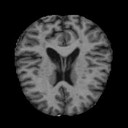

2. label = 0


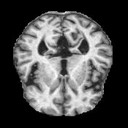

3. label = 3


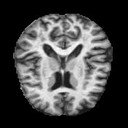

4. label = 3


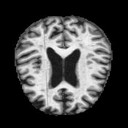

5. label = 2


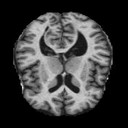

In [59]:
def display_images(df, n=5):
    """
    Display the first n grayscale images (numpy arrays) from df
    along with their labels. Assumes df has columns 'image' and 'label'.
    """
    for i, (_, row) in enumerate(df.head(n).iterrows(), start=1):
        pixels = row["image"]
        label = row.get("label", "")
        # Create a PIL image in 'L' mode (8-bit pixels, black and white)
        img = Image.fromarray(pixels.astype("uint8"), mode="L")
        print(f"{i}. label = {label}")
        display(img)
display_images(train_df)

1. label = 3


/tmp/ipython-input-3325884232.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(pixels.astype("uint8"), mode="L")


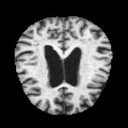

2. label = 0


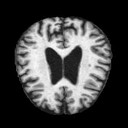

3. label = 2


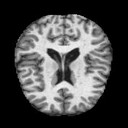

4. label = 3


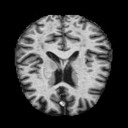

5. label = 0


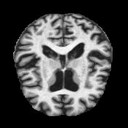

In [60]:
display_images(test_df)

In [61]:
train_df.shape

(5120, 2)

In [62]:
test_df.shape

(1280, 2)

In [63]:
train_df.columns

Index(['image', 'label'], dtype='object')

In [64]:
test_df.columns

Index(['image', 'label'], dtype='object')

# **Visualization Data**

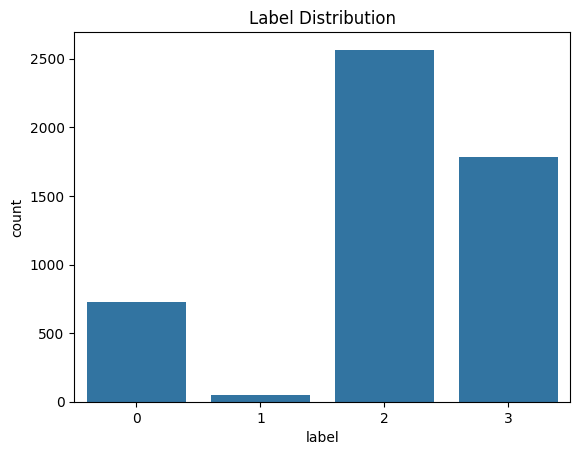

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=train_df)
plt.title("Label Distribution")
plt.show()

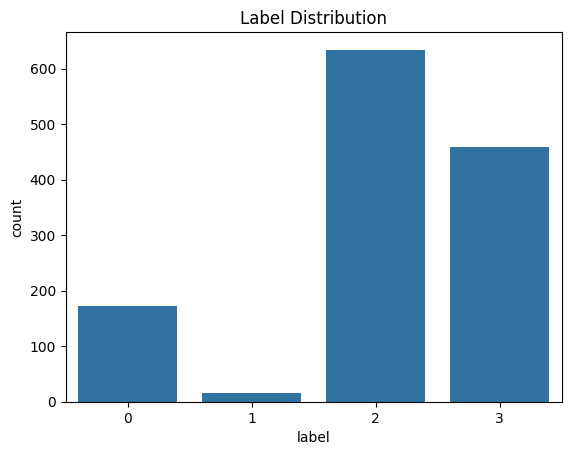

In [66]:
sns.countplot(x='label', data=test_df)
plt.title("Label Distribution")
plt.show()

# **Cleaning Data**

In [67]:
train_df['label'].value_counts()

,count
label,
2,2566
3,1781
0,724
1,49


In [68]:
test_df['label'].value_counts()

,count
label,
2,634
3,459
0,172
1,15


In [69]:
# Missing values
train_df.isnull().sum()

,0
image,0
label,0


In [70]:
type(train_df['image'][0])

numpy.ndarray

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
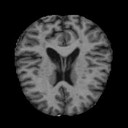

In [71]:
train_df['image'][0]

In [72]:
img = train_df['image'].iloc[0]
print(img.dtype)

uint8


In [73]:
# Verifying if data is scalled or not
for i in range(5):
    img = train_df['image'].iloc[i]
    print(f"Image {i} — dtype: {img.dtype}, min: {img.min()}, max: {img.max()}")

Image 0 — dtype: uint8, min: 0, max: 157
Image 1 — dtype: uint8, min: 0, max: 255
Image 2 — dtype: uint8, min: 0, max: 254
Image 3 — dtype: uint8, min: 0, max: 255
Image 4 — dtype: uint8, min: 0, max: 230


In [74]:
# Scalling data
train_df['image'] = train_df['image'].apply(lambda x: x / 255.0)
test_df['image']  = test_df['image'].apply(lambda x: x / 255.0)

In [75]:
# Verifying scalled data
for i in range(5):
    img = train_df['image'].iloc[i]
    print(f"Image {i} — dtype: {img.dtype}, min: {img.min()}, max: {img.max()}")

Image 0 — dtype: float64, min: 0.0, max: 0.615686274509804
Image 1 — dtype: float64, min: 0.0, max: 1.0
Image 2 — dtype: float64, min: 0.0, max: 0.996078431372549
Image 3 — dtype: float64, min: 0.0, max: 1.0
Image 4 — dtype: float64, min: 0.0, max: 0.9019607843137255


In [76]:
img = train_df['image'].iloc[0]
print(img.dtype)

float64


# **Split Data**

In [77]:
import numpy as np

# X: stack all images and add channel dimension
X = np.stack(train_df['image'].to_list())[..., np.newaxis]

# y: labels as 1D numpy array
y = train_df['label'].values

# Check shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (5120, 128, 128, 1)
y shape: (5120,)


In [78]:
from sklearn.model_selection import train_test_split

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keeps class distribution
)

print("X_train:", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (4096, 128, 128, 1)
X_test:  (1024, 128, 128, 1)
y_train: (4096,)
y_test: (1024,)


# **CNN Model**

In [79]:
# Initialize model
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras


cnn_model = keras.Sequential([
    keras.layers.Flatten(input_shape=[128, 128]),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(4, activation='sigmoid'),
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [80]:
# Compile model
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [81]:
# Fitting model
cnn_model.fit(X_train, y_train, epochs=15,)

Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4863 - loss: 1.1808
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5407 - loss: 0.9781
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5694 - loss: 0.8855
Epoch 4/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5998 - loss: 0.8396
Epoch 5/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6298 - loss: 0.8020
Epoch 6/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6607 - loss: 0.7515
Epoch 7/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6899 - loss: 0.7113
Epoch 8/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7116 - loss: 0.6968
Epoch 9/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7377 - loss: 0.6225
Epoch 10/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7424 - loss: 0.5916
Epoch 11/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7532 - loss: 0.5548
Epoch 12/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 

# **Evaluate Model**

In [82]:
# Evaluate model
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7231 - loss: 0.5842
Test Loss: 0.571997880935669
Test Accuracy: 0.73828125


In [83]:
print(y_test[0])

2


In [84]:
y_pred = cnn_model.predict(X_test)
print(np.argmax(y_pred[0]))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
2


# **Save & Load Model**

In [85]:
# Save model
cnn_model.save("alzheimers_cnn_model.h5")

# Load model
model = tf.keras.models.load_model("alzheimers_cnn_model.h5")